In [120]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [124]:
def print_result(df: pd.DataFrame, lasso: bool = False):
    X = df.drop(columns=['last_price'])
    y = df['last_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    scaler = StandardScaler()
    X_train_st = scaler.fit_transform(X_train)
    X_test_st = scaler.transform(X_test)
    if lasso:
        model = Lasso()
    else:
        model = LinearRegression()
    model.fit(X_train_st, y_train)
    if lasso:
        print(model.coef_)
    y_pred = model.predict(X_test_st)
    print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):.2f}\nR2:\t{r2_score(y_test, y_pred):.2f}')

First, read the data that was obtained after the first lab work

In [3]:
df = pd.read_csv('real_estate_data_after_first_task.csv')

In [4]:
print_result(df)

RMSE:	1894347.15
R2:	0.72


In [5]:
X = df.drop(columns=['last_price'])
y = df['last_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):.2f}\nR2:\t{r2_score(y_test, y_pred):.2f}')

RMSE:	1894347.15
R2:	0.72


In [6]:
max_name_lenght = max(map(lambda x: len(x), df.columns))

In [7]:
for col in df.columns:
    print(col.ljust(max_name_lenght + 1), df[col].nunique(), df[col].dtype, sep='\t')

total_images         	21	int64
last_price           	2540	float64
total_area           	1788	float64
rooms                	8	int64
ceiling_height       	129	float64
floors_total         	29	int64
living_area          	1412	float64
floor                	27	int64
is_apartment         	2	bool
studio               	2	bool
open_plan            	2	bool
kitchen_area         	771	float64
balcony              	6	int64
city_centers_nearest 	7117	float64
parks_around3000     	4	int64
ponds_around3000     	4	int64
airports_around30000 	2	bool
publishing_year      	5	int64
publishing_month     	12	int64
is_spb               	2	bool


In [8]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'bool']
numeric_columns = list(set(df.columns) - set(categorical_columns))

In [9]:
df_categorical = df[categorical_columns]
df_numeric = df[numeric_columns]

<i>last_price</i> is dependent variable ($y$)

# 1. Initial Multivariate Analysis.

## Correlation Matrix and Scatterplots
#### Identify linear and non-linear relationships between independent variables and between independent and dependent variables

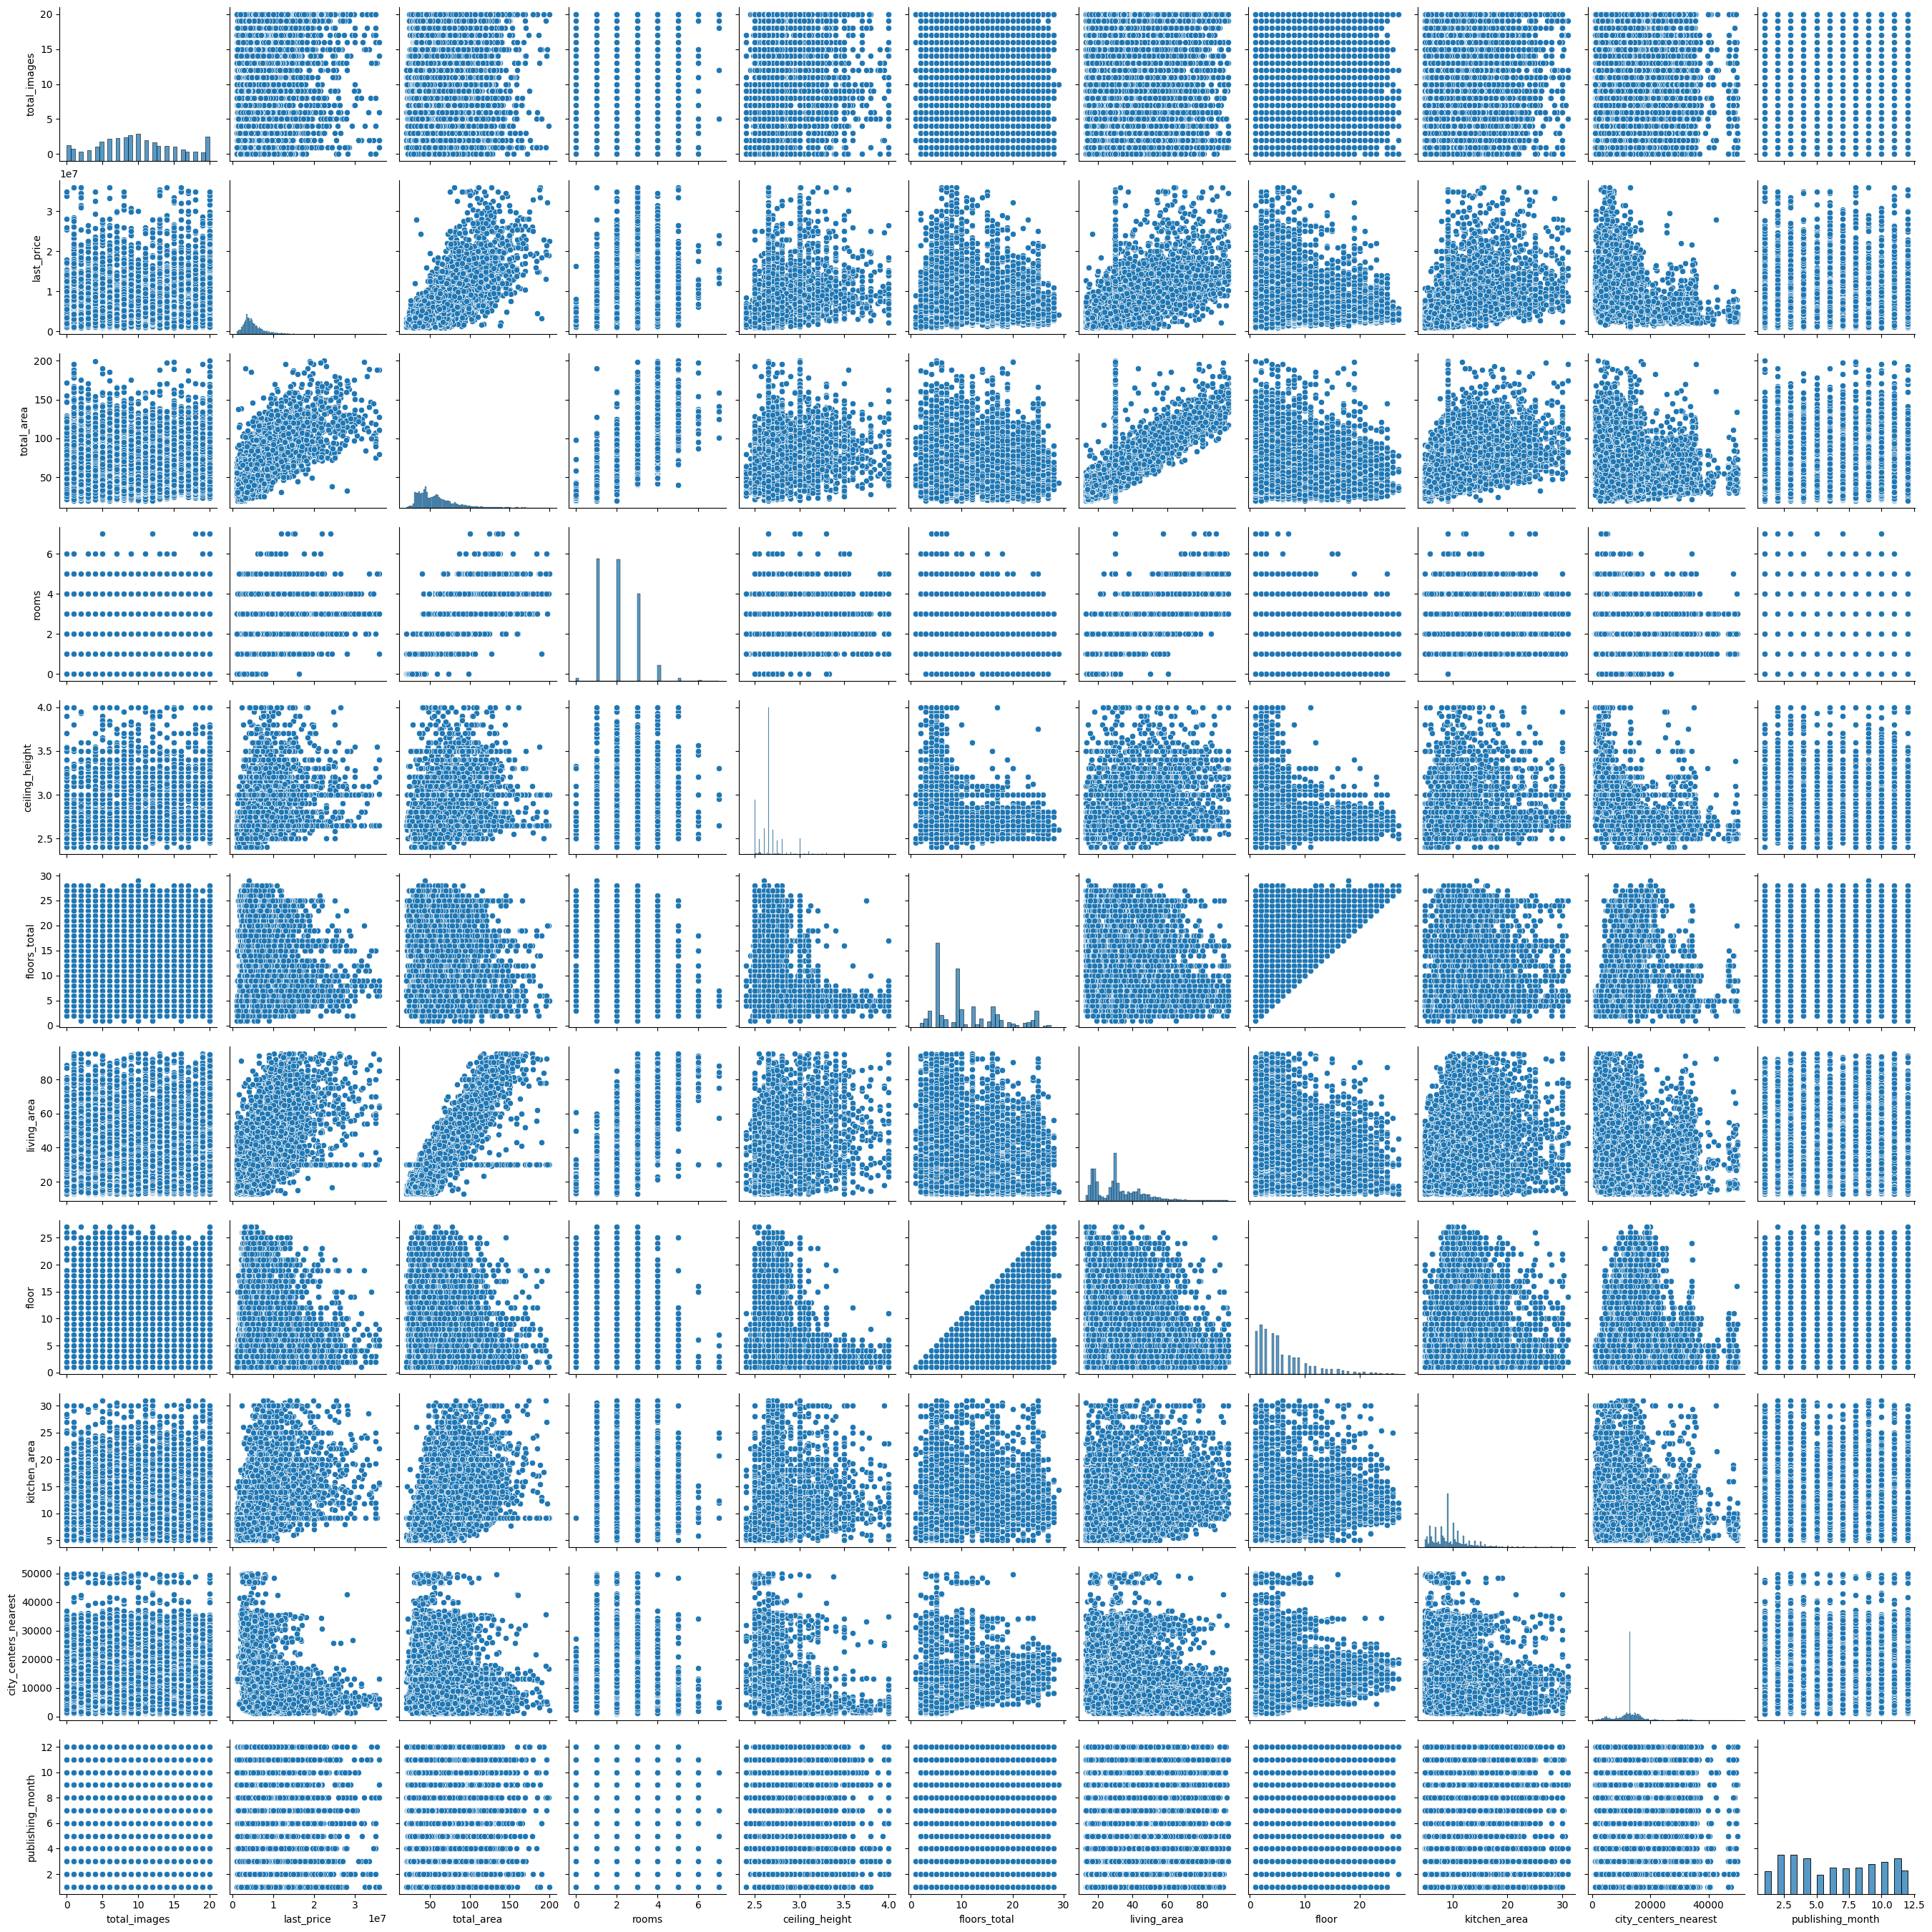

In [10]:
# Create a pair plot using seaborn
sns.pairplot(df_numeric[[col for col in df.columns if df[col].nunique() > 6]]);

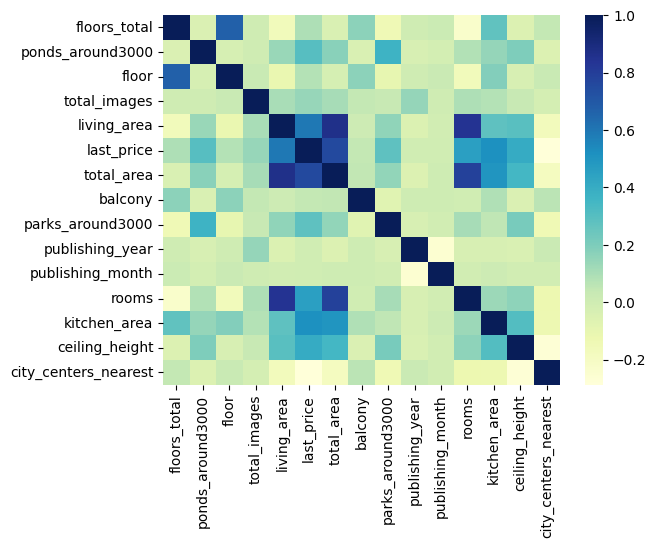

In [11]:
sns.heatmap(df_numeric.corr(),
            cmap="YlGnBu");

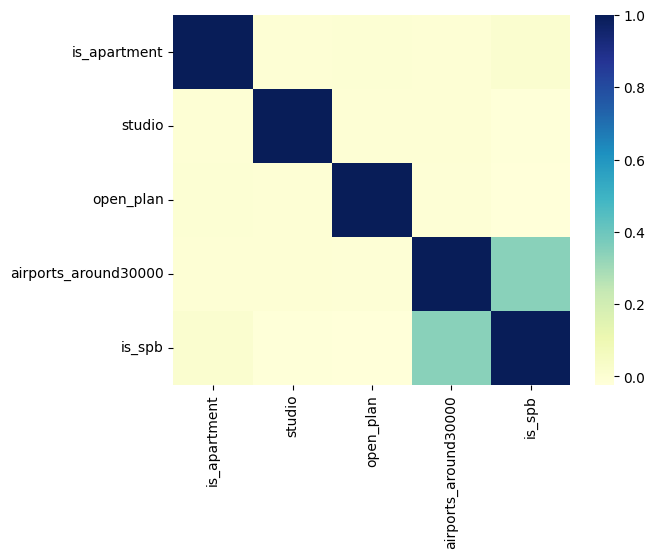

In [12]:
sns.heatmap(df_categorical.corr(method='spearman'),
            cmap="YlGnBu");

There are linear relationships between independent variables and between independent and dependent variables

In [13]:
CORR_THRESHOLD = 0.5

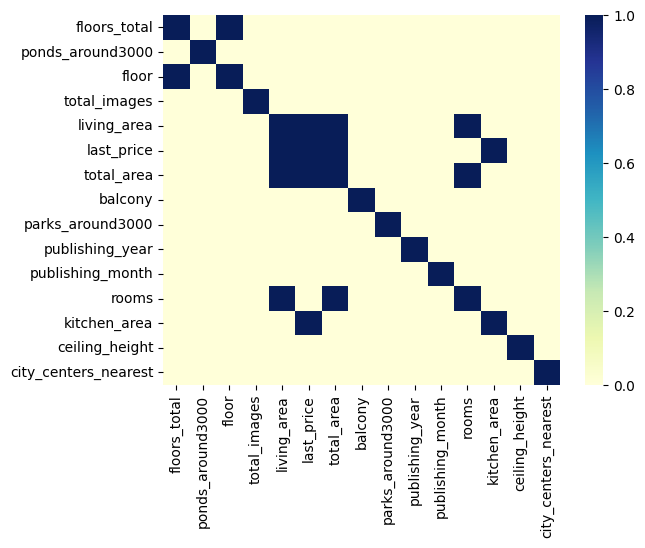

In [14]:
sns.heatmap(df_numeric.corr().abs() > CORR_THRESHOLD,
            cmap="YlGnBu");

In [15]:
strong_corrs = df_numeric.corr().abs()\
                 .stack()\
                 .reset_index()\
                 .rename({0: 'corr'}, axis=1)

In [16]:
strong_corrs = strong_corrs.query(f"corr > {CORR_THRESHOLD}")\
            .query(f"level_0 < level_1")\
            .sort_values(by=['level_0', 'level_1'])\
            .reset_index(drop=True)\
            .round(2)

In [17]:
adjacency_list = defaultdict(list)

for _, row in strong_corrs.iterrows():
    start = row['level_0']
    end = row['level_1']
    adjacency_list[start].append(end)
    adjacency_list[end].append(start)

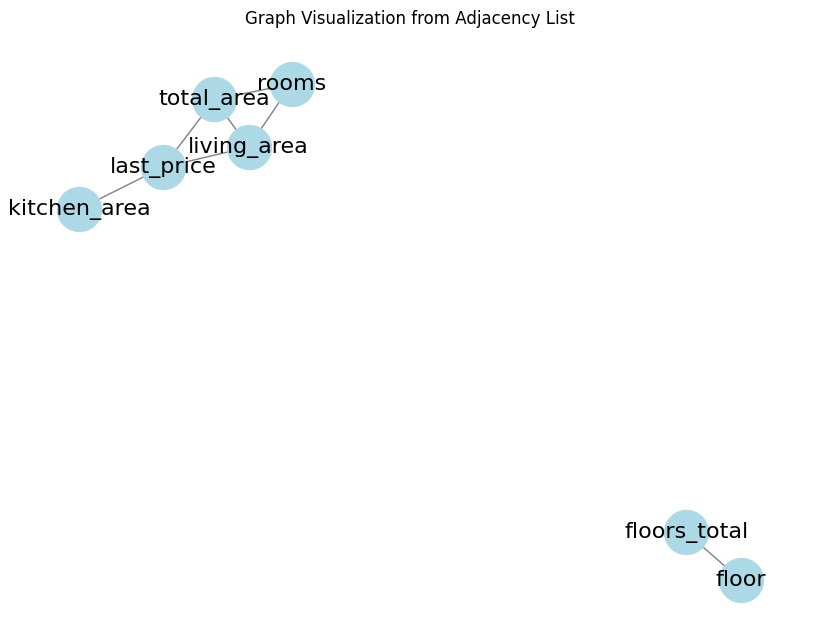

In [18]:
G = nx.Graph()
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=16, font_color='black', edge_color='gray')

plt.title("Graph Visualization from Adjacency List")
plt.show()

potentional to delete: floors_total, living_area

In [23]:
df_current = df.drop(['floors_total', 'living_area'], axis=1)

In [125]:
print_result(df, lasso=True)

[ 1.72610931e+05  3.22365347e+06 -9.94383840e+05  1.97533855e+05
  7.44639241e+04 -5.48949488e+04  8.07207619e+04  1.62556248e+03
 -2.10012428e+04 -1.48271901e+04  2.13203774e+05  4.01727824e+04
 -2.03870737e+05  2.90197057e+05  2.64682869e+05  1.12779189e+05
  5.81106662e+04  1.10747102e+03  6.45811776e+05]
RMSE:	1894347.56
R2:	0.72


In [126]:
print_result(df, lasso=False)

RMSE:	1894347.15
R2:	0.72


In [110]:
print_result(df_current)

RMSE:	1896812.78
R2:	0.72


In [114]:
# VIF dataframe
df = pd.read_csv('real_estate_data_after_first_task.csv')
X_numeric = df_numeric.drop(['last_price'], axis=1)
while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                       for i in range(len(X_numeric.columns))]
    ind_max = vif_data["VIF"].idxmax()
    max_vif = vif_data.iloc[ind_max]["VIF"]
    feature = vif_data.iloc[ind_max]["feature"]
    if max_vif < 10:
        print(f'Finish! We have {vif_data.shape[0]} columns')
        break
    else:
        X_numeric = X_numeric.drop([feature], axis=1)

Finish! We have 10 columns


In [115]:
vif_data

,feature,VIF
0,floors_total,7.221439
1,ponds_around3000,1.686575
2,floor,4.556263
3,total_images,3.867026
4,balcony,1.454485
5,parks_around3000,1.629917
6,publishing_month,3.808786
7,rooms,5.015079
8,kitchen_area,8.073233
9,city_centers_nearest,4.089469


In [100]:
new_numeric_columns = vif_data.feature.to_list()

In [101]:
total_columns = new_numeric_columns + categorical_columns + ['last_price']

In [102]:
new_df = df[total_columns]

In [103]:
new_df

,floors_total,ponds_around3000,floor,total_images,balcony,parks_around3000,publishing_month,rooms,kitchen_area,city_centers_nearest,is_apartment,studio,open_plan,airports_around30000,is_spb,last_price
0,23,1,9,0,1,1,1,3,13.00,13255.0,False,False,False,True,True,10018000.0
1,2,1,2,12,1,0,1,3,5.00,23111.0,False,False,False,True,True,4370000.0
2,22,1,18,6,2,0,1,1,12.00,14772.0,False,False,False,False,True,4500000.0
3,10,0,4,0,0,0,1,1,11.00,13096.5,False,False,False,False,False,3500000.0
4,25,0,13,4,0,0,1,2,8.32,13096.5,False,False,False,False,False,4100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21776,9,0,5,0,0,1,5,3,8.30,10641.0,False,False,False,False,True,5600000.0
21777,5,3,1,11,0,2,5,3,12.50,28860.0,False,False,False,True,False,9600000.0
21778,5,0,4,5,1,1,5,1,8.30,10717.0,False,False,False,True,True,5300000.0
21779,5,1,5,14,1,2,5,1,5.60,12804.0,False,False,False,False,True,3450000.0


In [105]:
print_result(new_df, lasso=False)

RMSE:	2421533.17
R2:	0.55
